In [1]:
import numpy as np
import sep
from astropy.io import fits
import matplotlib.pyplot as plt

# %matplotlib inline

In [ ]:
file_path = ""
data = fits.open(file_path)[0].data

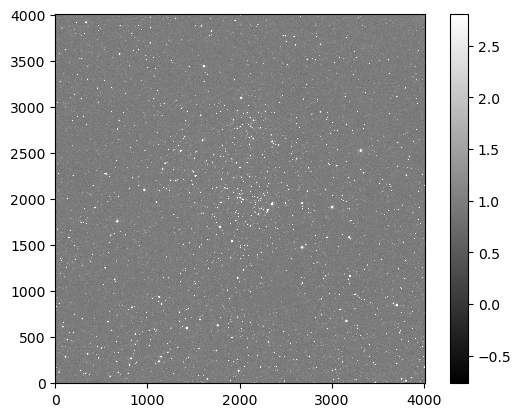

In [34]:
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar()
plt.show()

In [35]:
data = data.astype(data.dtype.newbyteorder('='))
# bkg = sep.Background(data)

ny, nx = data.shape
mask = np.zeros_like(data)
cx, cy = 2000, 2000   
w, h = 1000, 1000              
mask[cy - h//2 : cy + h//2, cx - w//2 : cx + w//2] = 1  


bkg = sep.Background(data, mask=mask, bw=64, bh=64, fw=3, fh=3)


# get a "global" mean and noise of the image background:
print(np.mean(data[mask == 0]))
print(np.mean(data))
print(bkg.globalback)
print(bkg.globalrms)

1.0176525
1.022321
0.9664306640625
0.06335475295782089


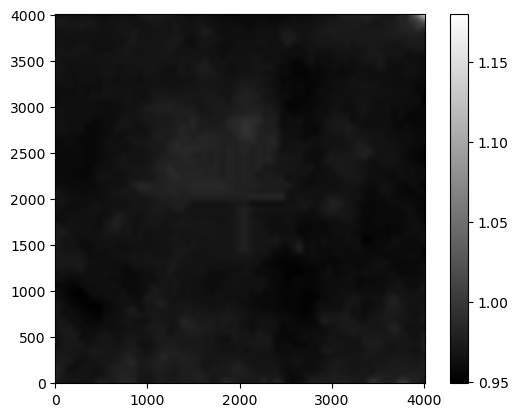

In [36]:
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()
# bkg_image = np.array(bkg) # equivalent to above

# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

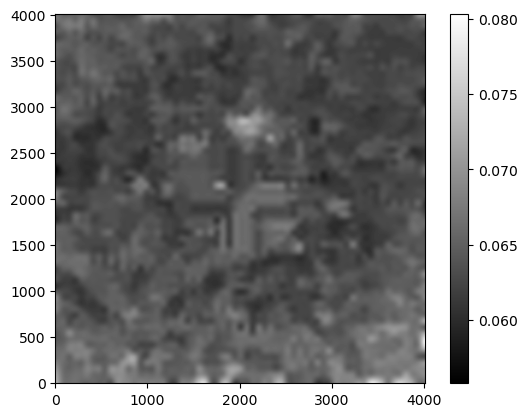

In [37]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

# show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

In [38]:
# subtract the background
data_sub = data - bkg

In [41]:
mask_sep = 1 - mask

# objects = sep.extract(data_sub, 10, err=bkg.globalrms, mask = mask_sep, minarea=15, deblend_nthresh=32, deblend_cont=0.0025)           # For M52 V filter len(object) = 350
# objects = sep.extract(data_sub, 8, err=bkg.globalrms, mask = mask_sep, minarea=15, deblend_nthresh=32, deblend_cont=0.0015)            # For M52 B filter len(object) = 253
# objects = sep.extract(data_sub, 8.5, err=bkg.globalrms, mask = mask_sep, minarea=25, deblend_nthresh=32, deblend_cont=0.005)           # For M52 U filter len(object) = 196
objects = sep.extract(data_sub, 8.5, err=bkg.globalrms, mask = mask_sep, minarea=25, deblend_nthresh=32, deblend_cont=0.005)           # For NGC6755 V filter len(object) = 196
# Number here means number * sigma where sigma is the global background RMS.

# how many objects were detected
len(objects)

239

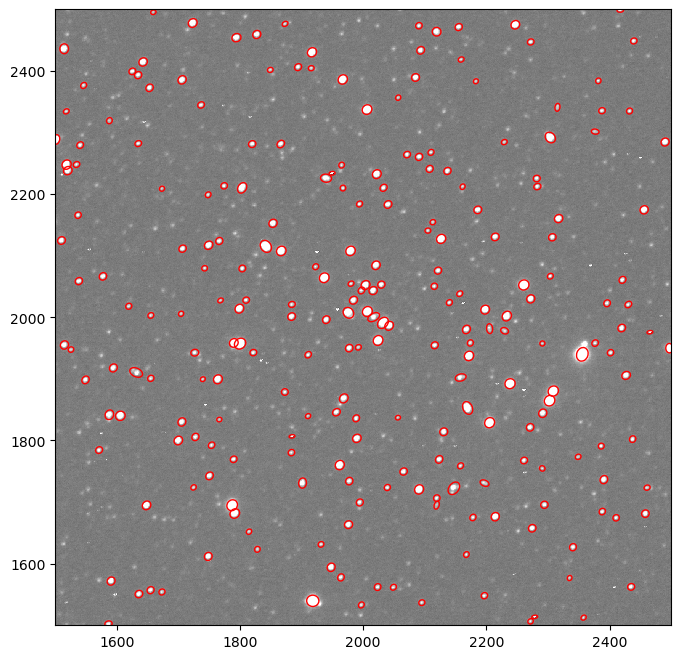

In [42]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots(figsize=(10, 8))
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

ax.set_xlim(1500, 2500)
ax.set_ylim(1500, 2500)

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

In [ ]:
from astropy.table import Table

data_table = Table(objects)

# Save objects extracted from sep into fits file
output_filename = ""
data_table.write(output_filename, format='fits', overwrite=True)
print(f"Data has been saved in {output_filename}")

Data has been saved in /Users/sangwonkang/Documents/UoE/TGP/extracted_NGC6755_V.fits


In [32]:
from astropy.samp import SAMPIntegratedClient

file_url = "file://" + output_filename

# Opening SAMP
client = SAMPIntegratedClient()
client.connect()  

params = {}
params["url"] = "file://" + output_filename
params["name"] = "Star Cluster"

message = {}
message["samp.mtype"] = "table.load.fits"
message["samp.params"] = params

# Sending objects information to TOPCAT
client.notify_all(message)

print("Succeed to send to TOPCAT")

client.disconnect()

Succeed to send to TOPCAT
